In [186]:
import numpy as np
import matplotlib.pyplot as plt
import struct
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as D
import os
import multiprocessing as mp
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [187]:
def loadData(file):
    try:
        File = open(file, 'rb')
    except IOError:
        print("open error")
        File.close()
        return
    
    # 读取文件头
    label = {
        'RECORD_BYTES':0,
        'FILE_RECORDS':0,
        'LABEL_RECORDS':0,
        '^IMAGE':0,
        '^IMAGE_PREFIX':0,
        '  ROWS':0,
        '  ROW_BYTES':0,
        '  LINES':0,
        }
    while True:
        line = File.readline()
        lbl = line.decode('utf8').replace('\t', '').strip('\n').split("=")
        if lbl[0] == 'END':# 文件头读完了
            break
        if lbl[0] in label:
            label[lbl[0]] = int(lbl[1])

    # 跳过空行
    skip = File.readline()
    
    # 线阵数量
    lines = label['  LINES']

    # 每个像素由32*32个像素取平均构成，坐标取第一个像素的起始点的纬度经度跨越的四分点
    height_pixels = 32
    width_pixels = 32
    
    height = int(lines/height_pixels)
    width = int(128/width_pixels)

    total = height*width

    skip_lines = lines%height_pixels

    # 读取经纬度列表，位置直接对应对应点的索引位置
    inf = File.readline(67*lines)
    inf = inf.decode('utf8').replace(' ', '').split("\t")# 整行经纬度表都在这里

    pos_lon = np.empty((total))# 经度
    pos_lat = np.empty((total))# 维度

    # 每个线阵的数据格式：2008-12-04T05:04:01.420Z	0	 121.2097	 -77.4942	 124.8695	 -77.4382	
    for i in range(height):
        for j in range(width):
            pos_lon[i*width + j] = float(inf[6*height_pixels*i + 2]) + j*(float(inf[6*height_pixels*i + 4]) - float(inf[6*height_pixels*i + 2]))/width
            pos_lat[i*width + j] = float(inf[6*height_pixels*i + 3])

    # 经纬度表后面有部分补全符号，剔除
    skip = File.readline(label['  ROWS']*label['  ROW_BYTES']-67*lines)

    # 读图像
    f = File.read()

    iim_np = np.empty((total,21))# iim图像记录，total，21个波段连续记录
    # print(iim_np)# test

    # 使用的波段记录
    useBand = [i for i in range(11,32)]
    usepBand = tuple(useBand)

    fmt = '>' + str(width_pixels) + 'f'
    offset = 0
    skipset = 4*128*lines# 对于不用的波段，全波段跳过一共n条线阵*128*4bytes的大小
    # print(skipset) # test

    for band in range(32):# test
        if band not in useBand:
            offset += skipset# 跳过整个波段
            continue
        # for line in range(label['  LINES']):
        pixel = 0
        while pixel < total:# 开始处理4个像素
            temp = np.zeros(width)

            # print(temp) # test

            for line in range(height_pixels):
                for unit in range(width):
                    temp[unit] += np.mean(struct.unpack_from(fmt, f, offset))
                    offset += struct.calcsize(fmt)
            for unit in range(width):
                iim_np[pixel][band - 11] = temp[unit]/4.0
                pixel += 1
        offset += 4*128*skip_lines# 尾部用不到的线阵
    print("a part finished")# test
    File.close()
    # print(np.shape(iim_np))
    return total, pos_lon, pos_lat, iim_np

In [188]:
def loadFileList(file):
    files = open(file,'r')
    f = files.readlines()
    files.close()
    return [item.replace('\n','').replace('\r','') for item in f]

In [ ]:
class Network(nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Network, self).__init__()
        self.fc = torch.nn.Linear(n_feature, n_hidden)
        self.out = torch.nn.Linear(n_hidden, n_output)

    def forward(self, x):
        x = F.relu(self.fc(x))
        x = self.out(x)
        x = F.sigmoid(x)
        x = 100*x
        return x

In [190]:
# 初始化模型
filestr='../network/model'
network = torch.load(filestr)

In [191]:
# 载入2C文件路径
file = 'fires101.txt'
fileList = loadFileList(file)

In [193]:
# 初始化图，全局变量！
# fig = np.zeros((8,900,1800))
fig = mp.Array('f', 8*900*1800)

In [194]:
def runs(file):
    # global fig
    # print('what happend')
    try:
        total_pixel, position_lon, position_lat, iim_np = loadData(file)
    except BaseException:
        print(file,'error!')
        return
    spec = torch.FloatTensor(iim_np)
    out = network(spec)
    figure = out.detach().numpy().T
    for band in range(8):
        for i in range(total_pixel):
            # fig[band][int(5*position_lat[i])+450][int(5*position_lon[i])+900] = figure[band][i]
            fig[band*900*1800+(int(5*position_lat[i])+450) *
                1800+int(5*position_lon[i])+900] = figure[band][i]

In [ ]:
# 多线程设定发
cores=mp.cpu_count()
pool=mp.Pool(processes=cores)

In [ ]:
# 多线程读写图
pool.map(runs,fileList)
# 把压缩的数组恢复
fig = np.array(list(fig)).reshape((8, 900, 1800))

经度划分为1800个密位，维度划分为900个密位，转换公式：

经度 lon = int(5*lon) + 900

纬度 lat = int(5*lat) + 450

In [ ]:
# 存取图，避免重复读取大数据
np.save("fig101.np",fig)
# b = np.load("fig.np")

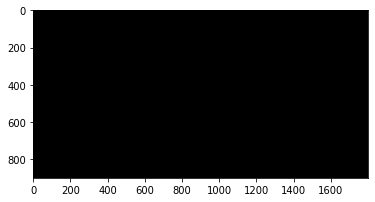

In [200]:
# 作图，先作一个维度看看
plt.imshow(fig[0], cmap ='gray')
plt.imsave('test.png', fig[0])
plt.imsave('testgray.png', fig[0], cmap='gray')